In [6]:
from importlib import reload
import numpy as np
import torch
import torch_geometric
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, fbeta_score, precision_recall_curve, average_precision_score
from torch.nn import functional as F
import matplotlib.pyplot as plt

import criterions
reload(criterions)
from criterions import ClassBalancedLoss

import data
reload(data)

import train
reload(train)
from train import train_GAT_GraphSVX_foroptuna, train_GraphSAGE_foroptuna

In [7]:

hyperparameters = {'hidden_channels': 15,
                   'num_heads': 3,
                    'dropout': 0.2,
                    'lr': 0.002,
                    'epochs': 1000,
                    'beta': 0.9999, 
                    'seed':1}

dataset='100K_accts_EASY25'

model, traindata, testdata, feature_names, target_names, running_train_loss, running_test_loss, accuracy = train_GraphSAGE_foroptuna(hyperparameters, verbose = True)

epoch: 1, train_loss: 0.3915, test_loss: 0.38588398694992065, accuracy: 0.9530, balanced_accuracy: 0.5001, precision: 0.0548, recall: 0.0009, f0.9999: 0.0017
epoch: 10, train_loss: 0.3539, test_loss: 0.3698829710483551, accuracy: 0.9531, balanced_accuracy: 0.5001, precision: 0.0645, recall: 0.0009, f0.9999: 0.0017


KeyboardInterrupt: 

In [8]:

hyperparameters = {'hidden_channels': 15,
                   'num_heads': 3,
                    'dropout': 0.2,
                    'lr': 0.001,
                    'epochs': 1000,
                    'beta': 0.9999,
                    'seed':1}

model_name = 'GAT'
dataset_name = '100K_accts_EASY25'

model, traindata, testdata, feature_names, target_names, running_train_loss, running_test_loss, accuracy = train_GAT_GraphSVX_foroptuna(hyperparameters, verbose = True)

Using device: cuda
Double check which dataset is being used.
number of samples per classes (train) = [76743, 23257]
number of samples per classes (test) = [76708, 23213]
Starting training with 1000 epochs.
epoch: 10, train_loss: 0.6529, test_loss: 0.6422, accuracy: 0.7643, precision: 0.1062, recall: 0.0020, fbeta: 0.0039
epoch: 20, train_loss: 0.6027, test_loss: 0.5911, accuracy: 0.7674, precision: 0.3626, recall: 0.0014, fbeta: 0.0028
epoch: 30, train_loss: 0.5660, test_loss: 0.5519, accuracy: 0.7676, precision: 0.4156, recall: 0.0014, fbeta: 0.0027
epoch: 40, train_loss: 0.5528, test_loss: 0.5404, accuracy: 0.7676, precision: 0.4737, recall: 0.0019, fbeta: 0.0039
epoch: 50, train_loss: 0.5398, test_loss: 0.5267, accuracy: 0.7658, precision: 0.3168, recall: 0.0069, fbeta: 0.0135
epoch: 60, train_loss: 0.5270, test_loss: 0.5135, accuracy: 0.7657, precision: 0.4136, recall: 0.0209, fbeta: 0.0399
epoch: 70, train_loss: 0.5125, test_loss: 0.4987, accuracy: 0.7666, precision: 0.4569, recal

In [13]:
# Save the model

torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparameters': hyperparameters,
    'traindata': traindata,
    'testdata': testdata,
    'feature_names': feature_names,
    'target_names': target_names,
    'running_train_loss': running_train_loss,
    'running_test_loss': running_test_loss,
    'accuracy': accuracy
}, f'trained_models/{model_name}_{dataset_name}.pth')

In [4]:
print(f'Shaple of traindata.x: {traindata.x.shape}')

Shaple of traindata.x: torch.Size([100000, 32])


In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    out = model.forward(testdata.x, testdata.edge_index)
    out = F.softmax(out, dim=1)
    y_pred = out.cpu().numpy().argmax(axis=1)
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

[[68689  8019]
 [ 8337 14876]]


0.35025114653854555
Average Precision = 0.6677764452909067


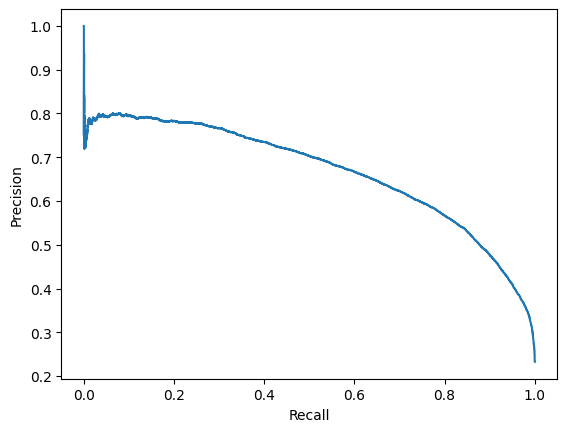

In [10]:
FPpercent = cm[0,1] / (cm[1,1] + cm[0,1])
print(FPpercent)

# Todo: precision recall curve
precision, recall, thresholds = precision_recall_curve(y_true, out[:,1].cpu().numpy())
average_precision = average_precision_score(y_true, out[:,1].cpu().numpy())

print(f'Average Precision = {average_precision}')

# print(thresholds)
# print(len(thresholds))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

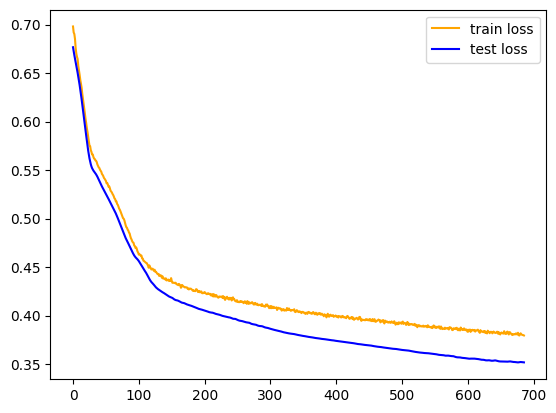

In [12]:
plt.plot(running_train_loss, label='train loss', color='orange')
plt.plot(running_test_loss, label='test loss', color='blue')
#plt.axvline(x=first_stop, color='red', linestyle='--')
plt.legend(['train loss', 'test loss'])
plt.show()

# Optuna

In [33]:
import optuna

# Best result found:
# acc = 0.81
# 'hidden_channels': 40, 'dropout': 0.12494751056760699, 'lr': 0.007997224211163154, 'epochs': 4200, 'beta': 0.9166784968106625

def objective(trial):
    hyperparameters = {'hidden_channels': trial.suggest_int('hidden_channels', 30, 50, step=5),
                   'num_heads': 3,
                    'dropout': trial.suggest_float('dropout', 0.1, 0.3),
                    'lr': trial.suggest_float('lr', 1e-4, 1e-2),
                    'epochs': 10000,
                    'beta': trial.suggest_float('beta', 0.999, 0.99999)}

    _, _, _, _, _, _, _, accuracy = train_GAT_GraphSVX_foroptuna(hyperparameters, verbose = False)
    return accuracy

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2024-04-10 09:06:23,833] A new study created in memory with name: no-name-ce958e9b-cdc7-4ad1-b420-9defa11c5bd9


Using device: cuda
Double check which dataset is being used.
number of samples per classes (train) = [76743, 23257]
number of samples per classes (test) = [76708, 23213]
Starting training with 4800 epochs.


[W 2024-04-10 09:06:31,260] Trial 0 failed with parameters: {'hidden_channels': 35, 'dropout': 0.1563223619764538, 'lr': 0.003261458425141236, 'epochs': 4800, 'beta': 0.9511311435541083} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/tomas/desktop/AMLvenv/EXPLORERvenv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1460068/2306059831.py", line 13, in objective
    _, _, _, _, _, _, _, accuracy = train_GAT_GraphSVX_foroptuna(hyperparameters, verbose = False)
  File "/home/tomas/desktop/flib/thesis_XAML/train.py", line 300, in train_GAT_GraphSVX_foroptuna
    out = model.forward(testdata.x, testdata.edge_index)
  File "/home/tomas/desktop/flib/thesis_XAML/modules.py", line 451, in forward
    x, attention_weights1 = self.conv1(x, edge_index, return_attention_weights=True)
  File "/home/tomas/desktop/AMLvenv/EXPLORERvenv/lib/python3.10/site-packa

KeyboardInterrupt: 

In [50]:
print(f"Best value: {study.best_value} (params: {study.best_params})")

Best value: 0.7677265039381111 (params: {'dropout': 0.19620499943945488, 'lr': 0.00793898695957484, 'epochs': 500, 'beta': 0.9023669878879975})


/tmp/ipykernel_1387467/2348212762.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
/tmp/ipykernel_1387467/2348212762.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)
/tmp/ipykernel_1387467/2348212762.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


array([<Axes: xlabel='beta', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='epochs'>,
       <Axes: xlabel='lr'>], dtype=object)

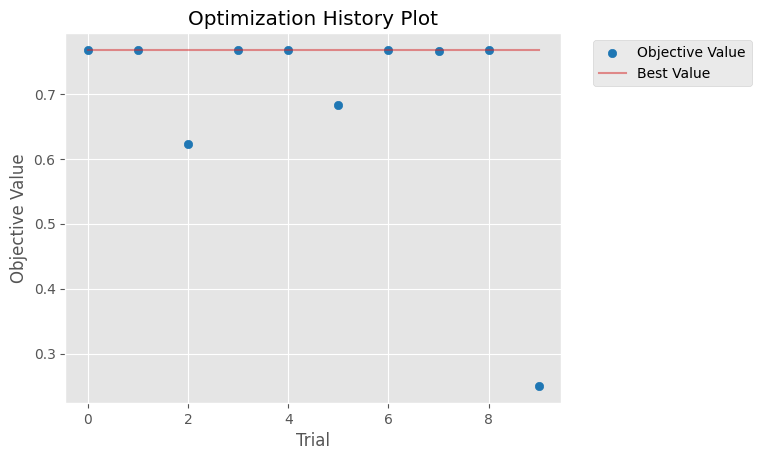

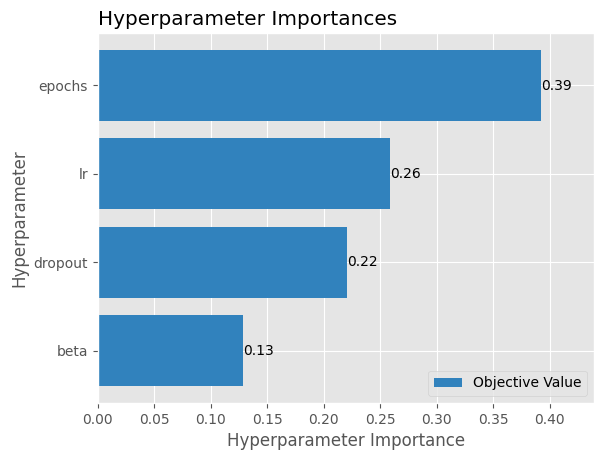

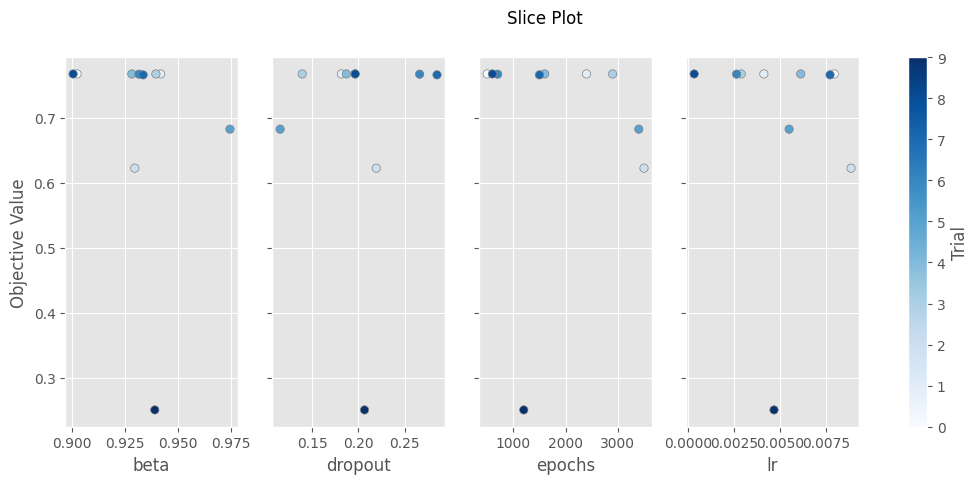

In [52]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_param_importances(study)
optuna.visualization.matplotlib.plot_slice(study)

In [13]:
from torch_geometric.nn import GCNConv, SAGEConv, GINEConv, GATConv, BatchNorm, Linear
import torch

class GAT_GraphSVX(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, dropout=0.3):
        super(GAT_GraphSVX, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dropout = dropout
        self.MLP_pre1 = torch.nn.Linear(in_channels, in_channels)
        self.MLP_pre2 = torch.nn.Linear(in_channels, in_channels)
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=dropout)
        self.conv3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, concat = False, dropout=dropout)
        self.MLP_post1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.MLP_post2 = torch.nn.Linear(hidden_channels, out_channels)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.return_attention_weights = False
    
    def set_return_attention_weights(self, return_attention_weights):
        if return_attention_weights == True or return_attention_weights == False:
            self.return_attention_weights = return_attention_weights
        else:
            raise ValueError('return_attention_weights must be either True or False')


    def forward(self, x, edge_index):
        # Pre processing layers
        x = self.MLP_pre1(x)
        x = self.MLP_pre2(x)
        
        # GNN layers
        x, attention_weights1 = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, attention_weights2 = self.conv2(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, attention_weights3 = self.conv3(x, edge_index, return_attention_weights=True)
        
        # Post processing layers
        x = self.MLP_post1(x)
        x = self.MLP_post2(x)
        
        # Activation function
        x = self.log_softmax(x) #<--- need to use NLLLoss
        
        if self.return_attention_weights:
            return x, attention_weights1, attention_weights2, attention_weights3
        else:
            return x
    
    # Adaption for Node Feature Vector (NFV) input
    def set_test_data(self, testdata):
        self.testdata = testdata
    
    def set_node_to_explain(self, node_to_explain):
        self.node_to_explain = node_to_explain
    
    def forward_NFVinput(self, node_feature_vec):
        print('Starting forward_LIME...')
        num_nodes = self.testdata.x.shape[0]
        
        node_feature_vec = node_feature_vec.reshape(-1,self.in_channels)
        num_samples = node_feature_vec.shape[0]
        out = torch.zeros((num_samples,2))
        print(f'Number of samples = {num_samples}')
        
        data_list = []
        
        print('Loading data...')
        for i in range(num_samples):
            new_graph = copy.deepcopy(self.testdata)
            new_graph.x[self.node_to_explain,:] = node_feature_vec[i,:]
            data_list.append(new_graph)
        print(f'number of graphs = {len(data_list)}')
        
        print('Loading data into a single batch...')
        #dataset = CustomDataset(data_list)
        batch = torch_geometric.data.Batch.from_data_list(data_list)
        
        print('Starting forward pass...')
        with torch.no_grad():
            out_tmp = self.forward(batch.x, batch.edge_index).exp()
        
        print(f'out_tmp.shape = {out_tmp.shape}')
        print('Extracting output...')
        for i in range(batch.num_graphs):
            out[i] = out_tmp[self.node_to_explain+i*num_nodes,:]
            
        print('Finished.')

        return out

In [14]:
def train_GAT_GraphSVX(hyperparameters = None, verbose = False):
    # Computing device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    print('Double check which dataset is being used.')
    
    # Data
    traindata = data.AmlsimDataset(node_file='data/simulation3/swedbank/train/nodes.csv', edge_file='data/simulation3/swedbank/train/edges.csv', node_features=True, node_labels=True).get_data()
    testdata = data.AmlsimDataset(node_file='data/simulation3/swedbank/test/nodes.csv', edge_file='data/simulation3/swedbank/test/edges.csv', node_features=True, node_labels=True).get_data()
    traindata = torch_geometric.transforms.ToUndirected()(traindata)
    testdata = torch_geometric.transforms.ToUndirected()(testdata)
    feature_names = ['sum','mean','median','std','max','min','in_degree','out_degree','n_unique_in','n_unique_out']
    target_names = ['not_sar','is_sar']
    
    # --- Add preprocessing here ---
    
    traindata = traindata.to(device)
    testdata = testdata.to(device)
    
    # Non-tunable hyperparameters
    in_channels = traindata.x.shape[1]
    out_channels = 2
    
    # Tunable hyperparamters
    hidden_channels = 10
    num_heads = 3
    dropout = 0.3
    lr = 0.005
    epochs = 400
    class_weights = [1, 3]
    
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    
    # Model
    model = GAT_GraphSVX(in_channels=in_channels,
                        hidden_channels=hidden_channels,
                        out_channels=out_channels,
                        num_heads=num_heads,
                        dropout=dropout)
    
    model = model.to(device)
    
    # Criterion and optimizer
    criterion = torch.nn.NLLLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Train model
    print(f'Starting training with {epochs} epochs.')
    # This model needs special input format, so we can't use the train_model function
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model.forward(traindata.x, traindata.edge_index)
        loss = criterion(out, traindata.y)
        loss.backward()
        optimizer.step()
        if verbose and ((epoch+1)%10 == 0 or epoch == epochs-1):
            model.eval()
            with torch.no_grad():
                out = model.forward(testdata.x, testdata.edge_index)
                loss = criterion(out, testdata.y)
                precision = precision_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
                recall = recall_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
                print(f'epoch: {epoch + 1}, loss: {loss:.4f}, precision: {precision:.4f}, recall: {recall:.4f}')
    print('Finished training.')
    
    return model, traindata, testdata, feature_names, target_names

In [15]:
model, traindata, testdata, feature_names, target_names = train_GAT_GraphSVX(verbose=True)

Using device: cuda
Double check which dataset is being used.
Starting training with 400 epochs.
epoch: 10, loss: 27.1826, precision: 0.0682, recall: 0.3770
epoch: 20, loss: 13.0339, precision: 0.1443, recall: 0.3885
epoch: 30, loss: 2.4645, precision: 0.1389, recall: 0.4345
epoch: 40, loss: 10.2796, precision: 0.0893, recall: 0.9954
epoch: 50, loss: 0.8300, precision: 0.0769, recall: 0.1931
epoch: 60, loss: 1.9467, precision: 0.0000, recall: 0.0000
epoch: 70, loss: 1.0454, precision: 0.1062, recall: 0.6782
epoch: 80, loss: 1.0321, precision: 0.0947, recall: 0.9586
epoch: 90, loss: 1.1073, precision: 0.0888, recall: 0.9632
epoch: 100, loss: 0.8257, precision: 0.0910, recall: 0.8437
epoch: 110, loss: 1.0332, precision: 0.0897, recall: 1.0000
epoch: 120, loss: 1.1550, precision: 0.0890, recall: 0.9816
epoch: 130, loss: 0.8288, precision: 0.0922, recall: 0.8414
epoch: 140, loss: 0.8739, precision: 0.0889, recall: 0.8575
epoch: 150, loss: 1.1634, precision: 0.0897, recall: 1.0000
epoch: 160